### Praca magisterska - Jan Matera

#### Wczytywanie danych

1. Wykorzystano autorski moduł `utils.py`, który zawiera funkcje służące do pobierania danych rynkowych oraz obliczania wskaźników technicznych.
2. Dane obejmują dzienne notowania cenowe spółki Apple (AAPL) od dnia **2009-01-01**.
3. Na podstawie danych cenowych skonstruowano zestaw wskaźników technicznych, które pełnią rolę zmiennych opisujących stan rynku.

---

##### Wykorzystywane wskaźniki techniczne

**1. Wskaźniki momentum i oscylatory**
- *Relative Strength Index* (**RSI**, 14 dni)
- *Moving Average Convergence Divergence* (**MACD**):
  - linia MACD,
  - linia sygnału,
  - histogram MACD

**2. Wskaźniki zmienności i położenia ceny**
- *Wstęgi Bollingera* (20 dni, ±2 odchylenia standardowe):
  - górna, środkowa i dolna wstęga,
  - znormalizowana pozycja ceny względem kanału Bollingera
- Dzienne stopy zwrotu
- 30-dniowa krocząca zmienność stóp zwrotu

**3. Wskaźniki trendu oparte na średnich kroczących**
- Proste średnie kroczące (*Simple Moving Average*, **SMA**):
  - SMA(5),
  - SMA(20)
- Wykładnicze średnie kroczące (*Exponential Moving Average*, **EMA**):
  - EMA(20),
  - EMA(50)
- Relacje średnich kroczących:
  - SMA(5) względem SMA(20),
  - EMA(20) względem EMA(50)

**4. Dodatkowe miary trendu i zmienności**
- *Rate of Change* (**ROC**, 20 dni)
- *Average Directional Index* (**ADX**, 14 dni)
- *Average True Range* (**ATR**, 14 dni) oraz ATR znormalizowany względem ceny


In [118]:
from src.utils import load_data

df_raw_AAPL = load_data('AAPL', '2009-01-01', '2025-01-01')
df_train_AAPL = df_raw_AAPL[df_raw_AAPL.index <= '2023-01-01']
df_test_AAPL = df_raw_AAPL[df_raw_AAPL.index > '2023-01-01']

#### Zapisanie danych do pliku: aapl.xlsx

In [119]:
df_raw_AAPL.to_excel('aapl.xlsx')

#### Konstrukcja środowiska Reinforcement Learning

W celu przeprowadzenia eksperymentów wykorzystano środowisko typu *TradingEnv* zgodne ze standardem Gymnasium, które symuluje proces podejmowania decyzji inwestycyjnych na rynku finansowym. Środowisko zostało skonfigurowane osobno dla zbioru treningowego oraz testowego, przy zachowaniu spójnych parametrów ekonomicznych i struktury decyzyjnej.
Biblioteka Gymnasium jest rozwijana przez m.in. Farama Foundation i powstała na bazie biblioteki Gym, utrzymywanej do 2021 roku przez twóców ChatGPT, OpenAI.

Gymnasium: https://gymnasium.farama.org

TradingEnv: https://gym-trading-env.readthedocs.io/en/latest/index.html

---

##### Funkcja nagrody

Funkcja nagrody została zdefiniowana jako logarytmiczna stopa zwrotu portfela pomiędzy kolejnymi krokami czasowymi. Dla kroku czasowego $t$ nagroda dana jest wzorem:

```math
r_t = \log\left(\frac{V_t}{V_{t-1}}\right),
```

gdzie:
- $V_t$ oznacza wartość portfela w chwili $t$,
- $V_{t-1}$ oznacza wartość portfela w poprzednim kroku czasowym.

Taka definicja nagrody zapewnia:
- addytywność nagród w czasie, co jest pożądane z punktu widzenia algorytmów uczenia ze wzmocnieniem,
- bezpośrednią interpretację ekonomiczną jako logarytmiczną stopę zwrotu portfela.

---

##### Środowisko treningowe

Środowisko treningowe zostało skonstruowane w celu uczenia polityki inwestycyjnej agenta:

- instrument bazowy: **Apple (AAPL)**,
- dane wejściowe: zbiór treningowy danych dziennych,
- długość okna obserwacji: **21 dni**:
  - wprowadzenie okna obserwacji polega na redefinicji stanu $s_t$ jako wektora kolejnych obserwacji $o_t$,
  - pozwala to częściowo przywrócić własność Markowa w problemie o charakterze POMDP,
- przestrzeń akcji, które może wykonać agent:
  - `-1` – pozycja krótka (short),
  - `0` – brak pozycji (flat),
  - `1` – pozycja długa (long),
- pozycja początkowa: losowa,
- koszty transakcyjne: **0.01%** wartości transakcji,
- koszt utrzymywania pozycji krótkiej: **11% rocznie**,
- początkowa wartość portfela: **10 000 jednostek waluty**,
- maksymalna długość epizodu: **126 kroków**,
- sprawdzanie poprawności środowiska (env checker): wyłączone.

Losowa inicjalizacja pozycji początkowej pozwala agentowi uczyć się polityki odpornej na różne warunki startowe.

---

##### Środowisko testowe

Środowisko testowe służy do ewaluacji wyuczonej polityki w warunkach out-of-sample:

- instrument bazowy: **Apple (AAPL)**,
- dane wejściowe: zbiór testowy danych dziennych,
- długość okna obserwacji: **21 dni**,
- przestrzeń akcji: identyczna jak w środowisku treningowym,
- pozycja początkowa: brak pozycji,
- koszty transakcyjne i koszt shortowania: identyczne jak w treningu,
- początkowa wartość portfela: **10 000 jednostek waluty**,
- długość epizodu: pełny zakres danych testowych.

Deterministyczna pozycja początkowa w środowisku testowym umożliwia porównywalną i replikowalną ewaluację wyników modelu.

---

##### Spójność środowisk

Oba środowiska – treningowe i testowe – zachowują identyczną strukturę przestrzeni stanów, akcji oraz kosztów ekonomicznych. Różnią się jedynie:

- zakresem danych wejściowych,
- sposobem inicjalizacji pozycji,
- maksymalną długością epizodu.

In [120]:
import gymnasium as gym
import gym_trading_env
import numpy as np

def reward_function(history):
    return np.log(history["portfolio_valuation", -1] / history["portfolio_valuation", -2]) #log (p_t / p_t-1 )

env_train = gym.make(
        "TradingEnv",
        name= "AAPL",
        df = df_train_AAPL,
        windows= 21,
        positions = [-1, 0, 1], # From -1 (=SHORT), to +1 (=LONG)
        initial_position = 'random', #Initial position
        trading_fees = 0.04/100, # 0.2% per stock buy / sell
        borrow_interest_rate = 0.11 / 252,
        reward_function = reward_function,
        portfolio_initial_value = 10_000, # in FIAT (here, USD)
        max_episode_duration = 126,
        disable_env_checker= True,
        verbose=0
    )

env_test = gym.make(
        "TradingEnv",
        name= "AAPL",
        df = df_test_AAPL,
        windows= 21,
        positions = [-1, 0, 1], # From -1 (=SHORT), to +1 (=LONG)
        initial_position = 0, #Initial position
        trading_fees = 0.04/100, # 0.01% per stock buy / sell
        borrow_interest_rate = 0.11 / 252,
        reward_function = reward_function,
        portfolio_initial_value = 10_000, # in FIAT (here, USD)
        max_episode_duration = "max",
        disable_env_checker= True,
        verbose=0
    )

In [ ]:
"""
from itertools import product
import os

param_grid = {
    "learning_rate": [3e-4, 1e-4],
    "batch_size": [128, 256],
    "target_update_interval": [2000, 5000],
}


keys = list(param_grid.keys())
param_combinations = list(product(*param_grid.values()))

import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor

best_score = -np.inf
best_params = None
best_model_path = None

base_log_dir = "./logs/grid_AAPL"
os.makedirs(base_log_dir, exist_ok=True)

for i, values in enumerate(param_combinations):
    params = dict(zip(keys, values))

    print(f"Run {i+1}/{len(param_combinations)}")
    print("Params:", params)

    run_dir = os.path.join(base_log_dir, f"run_{i}")
    best_model_dir = os.path.join(run_dir, "best_model")
    os.makedirs(best_model_dir, exist_ok=True)

    env_train_i = Monitor(env_train.unwrapped)
    env_test_i = Monitor(env_test.unwrapped)

    eval_callback = EvalCallback(
        env_test_i,
        best_model_save_path=best_model_dir,
        log_path=run_dir,
        eval_freq=10_000,
        deterministic=True,
        verbose=0
    )

    model = DQN(
        policy="MlpPolicy",
        env=env_train_i,
        learning_rate=params["learning_rate"],
        gamma=0.99,
        buffer_size=100_000,
        batch_size=params["batch_size"],
        learning_starts=2_000,
        train_freq=1,
        gradient_steps=1,
        target_update_interval=params["target_update_interval"],
        exploration_fraction=0.5,
        exploration_final_eps=0.05,
        policy_kwargs=dict(net_arch=[128, 64]),
        verbose=0
    )

    model.learn(
        total_timesteps=200_000,
        callback=eval_callback,
        log_interval=50
    )

    eval_data = np.load(os.path.join(run_dir, "evaluations.npz"))
    mean_rewards = eval_data["results"].mean(axis=1)
    best_run_score = mean_rewards.max()

    print("Best eval reward:", best_run_score)

    if best_run_score > best_score:
        best_score = best_run_score
        best_params = params
        best_model_path = best_model_dir
"""

In [ ]:
#print("NAJLEPSZA KONFIGURACJA")
#print(best_params)
#print(f"Najlepsza średnia nagroda: {best_score}")
#print(f"Model zapisany w: {best_model_path}")

##### Uczenie agenta DQN

Proces uczenia agenta oparty jest na algorytmie Deep Q-Network (DQN) zaimplementowanym w bibliotece *Stable-Baselines3*. W pierwszym kroku tworzona jest struktura służąca do zapisu logów treningowych oraz najlepszego modelu wyłonionego w trakcie uczenia.

Środowiska treningowe i testowe są opakowane klasą `Monitor`, która umożliwia rejestrowanie długości epizodów, skumulowanych nagród oraz dodatkowych statystyk wykorzystywanych w procesie ewaluacji.

Do okresowej oceny jakości wyuczonej polityki zastosowano mechanizm *callback*, zdefiniowany przy użyciu klasy `EvalCallback`. Ewaluacja przeprowadzana jest co 10 000 kroków uczenia na środowisku testowym, a najlepszy model — rozumiany jako model osiągający najwyższą średnią nagrodę — jest zapisywany na dysku. Podczas ewaluacji wykorzystywana jest deterministyczna wersja polityki.

Agent DQN korzysta z wielowarstwowej sieci neuronowej typu MLP, w której architektura składa się z dwóch warstw ukrytych o rozmiarach odpowiednio 128 i 64 neuronów. Sieć aproksymuje funkcję wartości akcji $Q(s,a)$.

Parametry uczenia zostały dobrane następująco:
- współczynnik dyskontowania nagród $\gamma = 0.99$,
- współczynnik uczenia $\alpha = 0.0003$,
- rozmiar bufora doświadczeń: 100 000 obserwacji,
- liczba kroków rozgrzewkowych przed rozpoczęciem uczenia: 2 000,
- rozmiar minibatcha: 64,
- aktualizacja sieci docelowej co 1 000 kroków,
- strategia eksploracji typu *ε-greedy*, z liniowym zmniejszaniem parametru eksploracji od wartości początkowej do $\varepsilon_{\text{final}} = 0.05$,
- frakcja kroków przeznaczonych na eksplorację: 40%.

Uczenie agenta przeprowadzane jest przez 250 000 kroków czasowych środowiska. Postęp uczenia, w tym wartości funkcji straty oraz średnie nagrody, jest logowany co 50 iteracji. Ewaluacja modelu oraz zapis najlepszego wariantu odbywają się automatycznie w trakcie procesu uczenia.


In [147]:
import os
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback

base_log_dir = "./logs/grid_AAPL"
os.makedirs(base_log_dir, exist_ok=True)

run_log_dir = os.path.join(base_log_dir, f"run_AAPL")
best_model_dir = os.path.join(run_log_dir, "best_model")
os.makedirs(run_log_dir, exist_ok=True)

env_train = Monitor(env_train)
env_test = Monitor(env_test)

eval_callback = EvalCallback(
    env_test,
    best_model_save_path=best_model_dir,
    log_path=run_log_dir,
    eval_freq=5_000,
    deterministic=True
)

model = DQN(
    policy="MlpPolicy",
    env=env_train,
    learning_rate=0.0003,
    buffer_size=100_000,
    learning_starts=2_000,
    batch_size=256,
    tau=1.0,
    gamma=0.99,
    train_freq=1,
    gradient_steps=1,
    target_update_interval=5000,
    exploration_fraction=0.5,
    exploration_final_eps=0.05,
    policy_kwargs=dict(net_arch=[128, 64]),
    verbose=1
)

model.learn(
    total_timesteps=500_000,
    callback=eval_callback,

    log_interval=50
)

Using cpu device
Wrapping the env in a DummyVecEnv.
Eval num_timesteps=5000, episode_reward=0.17 +/- 0.00
Episode length: 481.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 481      |
|    mean_reward      | 0.169    |
| rollout/            |          |
|    exploration_rate | 0.981    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 7.13e-05 |
|    n_updates        | 2999     |
----------------------------------
New best mean reward!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -0.0293  |
|    exploration_rate | 0.976    |
| time/               |          |
|    episodes         | 50       |
|    fps              | 523      |
|    time_elapsed     | 11       |
|    total_timesteps  | 6250     |
| train/              |          |


##### Analiza wyników ewaluacji agenta

Po zakończeniu procesu uczenia agenta wyniki okresowych ewaluacji są zapisywane automatycznie przez mechanizm `EvalCallback` w pliku `evaluations.npz`. Plik ten zawiera informacje o momentach czasowych, w których przeprowadzano ewaluację, oraz o uzyskanych nagrodach.

Z pliku wczytywane są:
- wektor $\texttt{timesteps}$, zawierający numery kroków uczenia, w których wykonywano ewaluację,
- macierz $\texttt{results}$ o wymiarach $(n_{\text{eval}}, n_{\text{episodes}})$, zawierająca wartości nagród uzyskanych w poszczególnych epizodach testowych dla każdej ewaluacji.

Dla każdej ewaluacji obliczana jest średnia nagroda:

```math
\bar{R}_i = \frac{1}{N} \sum_{j=1}^{N} R_{i,j},
```

gdzie:
- $R_{i,j}$ oznacza nagrodę uzyskaną w $j$-tym epizodzie podczas $i$-tej ewaluacji,
- $N$ oznacza liczbę epizodów ewaluacyjnych.

Następnie identyfikowany jest krok uczenia, w którym agent osiągnął najwyższą średnią nagrodę. Odpowiada on indeksowi:

```math
i^* = \arg\max_i \bar{R}_i.


In [148]:
import numpy as np

data = np.load("logs/grid_AAPL/run_AAPL/evaluations.npz")

timesteps = data["timesteps"]      # timesteps, kiedy robiono eval
results = data["results"]          # shape: (n_evals, n_eval_episodes)

mean_rewards = results.mean(axis=1)

best_idx = mean_rewards.argmax()

print("Najlepszy eval timestep:", timesteps[best_idx])
print("Najlepsza średnia nagroda:", mean_rewards[best_idx])

Najlepszy eval timestep: 460000
Najlepsza średnia nagroda: 0.62018


##### Ewaluacja strategii agenta na danych testowych

Po zakończeniu procesu uczenia do dalszej analizy wykorzystywany jest najlepszy zapisany model algorytmu DQN. Model ten jest wczytywany z dysku i używany do generowania deterministycznych decyzji inwestycyjnych na zbiorze testowym.

Środowisko testowe jest resetowane do stanu początkowego, a następnie inicjalizowany jest wektor przechowujący historię wartości portfela. Jako pierwszą obserwację zapisywana jest początkowa wartość portfela, odczytana bezpośrednio ze stanu środowiska.

W kolejnych krokach czasowych agent:
- obserwuje aktualny stan środowiska,
- wybiera akcję zgodnie z wyuczoną polityką (bez eksploracji),
- wykonuje krok w środowisku testowym,
- zapisuje bieżącą wartość portfela po uwzględnieniu zmian cen, kosztów transakcyjnych oraz kosztów finansowania pozycji.

Proces ten trwa do momentu zakończenia epizodu, tj. spełnienia warunku `done` lub `truncated`.

Na podstawie zarejestrowanej sekwencji wartości portfela $\{V_t\}_{t=0}^T$ obliczane są logarytmiczne stopy zwrotu portfela:

```math
r_t = \log\left(\frac{V_t}{V_{t-1}}\right),
```

które stanowią bezpośrednią miarę efektywności strategii inwestycyjnej agenta. Tak zdefiniowane stopy zwrotu są addytywne w czasie i mogą być bezpośrednio wykorzystane do porównań z innymi strategiami, takimi jak strategia buy-and-hold czy proste reguły techniczne.

In [149]:
from stable_baselines3 import DQN
import numpy as np

best_model = DQN.load("logs/grid_AAPL/run_AAPL/best_model/best_model.zip")

obs, _ = env_test.reset()

portfolio_values = [
    env_test.unwrapped.historical_info["portfolio_valuation", -1]
]

while True:
    action, _ = best_model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env_test.step(action)

    portfolio_values.append(
        env_test.unwrapped.historical_info["portfolio_valuation", -1]
    )

    if done or truncated:
        break

portfolio_values = np.array(portfolio_values)
returns = np.log(portfolio_values[1:] / portfolio_values[:-1])

##### Porównanie strategii inwestycyjnych na danych testowych

W celu oceny jakości strategii wyuczonej przez agenta DQN przeprowadzono porównanie jej wyników z prostymi, klasycznymi strategiami inwestycyjnymi. Porównanie realizowane jest na podstawie skumulowanych logarytmicznych stóp zwrotu, co umożliwia bezpośrednią i addytywną w czasie interpretację wyników.

Jako punkt odniesienia wykorzystano następujące strategie:

- **Strategia agenta DQN**  
  Skumulowane logarytmiczne stopy zwrotu agenta, obliczone na podstawie rzeczywistej wartości portfela w środowisku testowym, uwzględniającej koszty transakcyjne oraz koszt finansowania pozycji krótkiej.

- **Strategia Buy & Hold**  
  Strategia pasywna polegająca na utrzymywaniu pozycji długiej w instrumencie przez cały okres testowy. Logarytmiczne stopy zwrotu obliczane są na podstawie dziennych cen zamknięcia.

- **Strategia momentum (1-lag)**  
  Prosta strategia momentum, w której znak pozycji w danym kroku zależy od znaku stopy zwrotu z poprzedniego dnia. Pozycja długa zajmowana jest po dodatnim zwrocie, a krótka po ujemnym.

- **Strategia przecięcia średnich kroczących (SMA 10/50)**  
  Strategia trendowa oparta na przecięciu krótkookresowej (10 dni) i długookresowej (50 dni) prostej średniej kroczącej. Pozycja długa zajmowana jest w okresach, gdy krótsza średnia znajduje się powyżej dłuższej, a brak pozycji w przeciwnym przypadku.

Wszystkie strategie przedstawione są na jednym wykresie w postaci skumulowanych logarytmicznych stóp zwrotu, co umożliwia wizualną ocenę ich względnej efektywności, stabilności oraz zachowania w różnych fazach rynku. Takie zestawienie pozwala określić, czy strategia oparta na uczeniu ze wzmocnieniem oferuje przewagę względem prostych reguł inwestycyjnych.


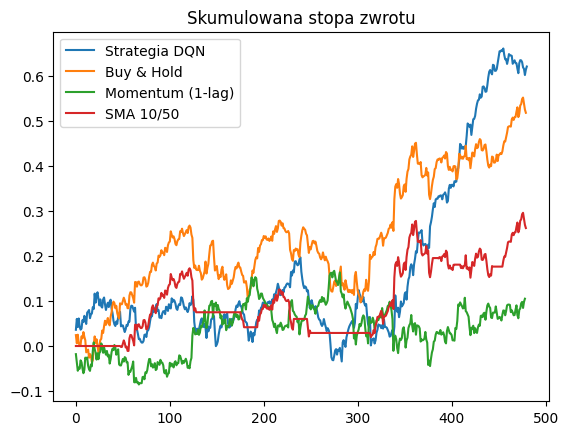

In [165]:
import matplotlib.pyplot as plt
import pandas as pd

# strategia agenta
plt.plot(np.cumsum(returns), label="Strategia DQN")

# Buy & Hold
close = df_test_AAPL.iloc[21:]["close"].values
returns_bh = np.log(close[1:] / close[:-1])
plt.plot(np.cumsum(returns_bh), label="Buy & Hold")

# Momentum lag
returns_mom = np.sign(returns_bh[:-1]) * returns_bh[1:]
plt.plot(np.cumsum(returns_mom), label="Momentum (1-lag)")

#SMA cross
short = 10
long = 50

price = close
sma_s = pd.Series(price).rolling(short).mean()
sma_l = pd.Series(price).rolling(long).mean()

signal = (sma_s > sma_l).astype(int).values[1:]
returns_sma = signal * returns_bh

plt.plot(np.cumsum(returns_sma), label="SMA 10/50")

plt.legend()
plt.title("Skumulowana stopa zwrotu")
plt.show()


In [166]:
from stable_baselines3 import DQN
import numpy as np

best_model = DQN.load("logs/grid_AAPL/run_AAPL/best_model/best_model.zip")

obs, _ = env_test.reset()

while True:
    action, _ = best_model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env_test.step(action)
    if done or truncated:
        break

# skrót
hist = env_test.unwrapped.historical_info

In [167]:
import numpy as np
import matplotlib.pyplot as plt

dates = np.asarray(hist["date"], dtype="datetime64[ns]")
portfolio_values = np.asarray(hist["portfolio_valuation"], dtype=np.float64)
positions = np.asarray(hist["position"], dtype=np.float64)
rewards = np.asarray(hist["reward"], dtype=np.float64)

cum_max = np.maximum.accumulate(portfolio_values)
drawdowns = (portfolio_values - cum_max) / cum_max
max_dd = drawdowns.min()

aligned_rewards = rewards[1:]
aligned_positions = positions[:-1]

long_rets = aligned_rewards[aligned_positions > 0]
short_rets = aligned_rewards[aligned_positions < 0]

initial_value = portfolio_values[0]
bh_values = np.empty_like(portfolio_values)
bh_values[0] = initial_value
bh_values[1:] = initial_value * (close / close[0])

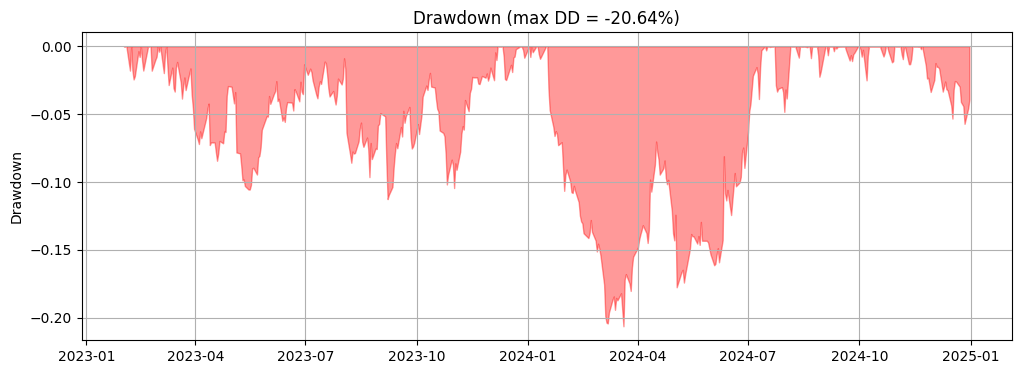

In [168]:
plt.figure(figsize=(12,4))
plt.fill_between(dates, drawdowns, 0, color="red", alpha=0.4)
plt.title(f"Drawdown (max DD = {max_dd:.2%})")
plt.ylabel("Drawdown")
plt.grid(True)
plt.show()


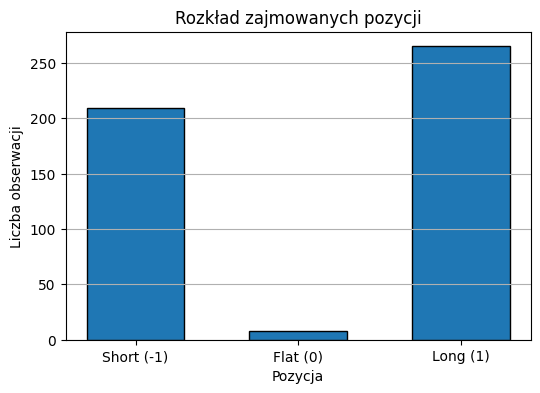

In [169]:
values, counts = np.unique(positions, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar(values, counts, width=0.6, edgecolor="black")

plt.xticks(values, ["Short (-1)", "Flat (0)", "Long (1)"])
plt.title("Rozkład zajmowanych pozycji")
plt.xlabel("Pozycja")
plt.ylabel("Liczba obserwacji")
plt.grid(axis="y")

plt.show()

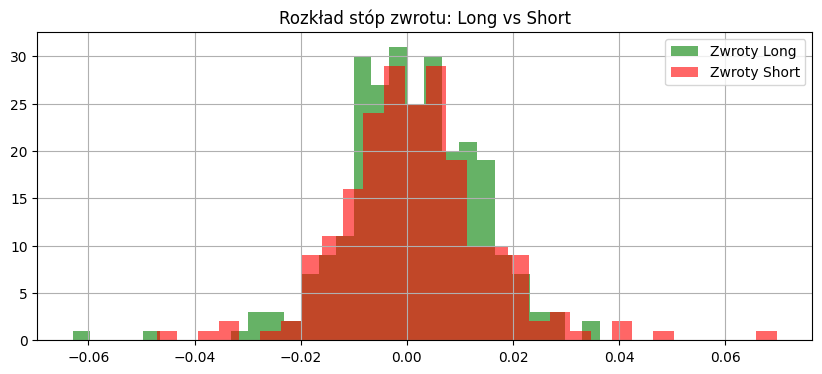

In [170]:
plt.figure(figsize=(10,4))
plt.hist(long_rets, bins=30, alpha=0.6, label="Zwroty Long", color='green')
plt.hist(short_rets, bins=30, alpha=0.6, label="Zwroty Short", color='red')
plt.title("Rozkład stóp zwrotu: Long vs Short")
plt.legend()
plt.grid(True)
plt.show()

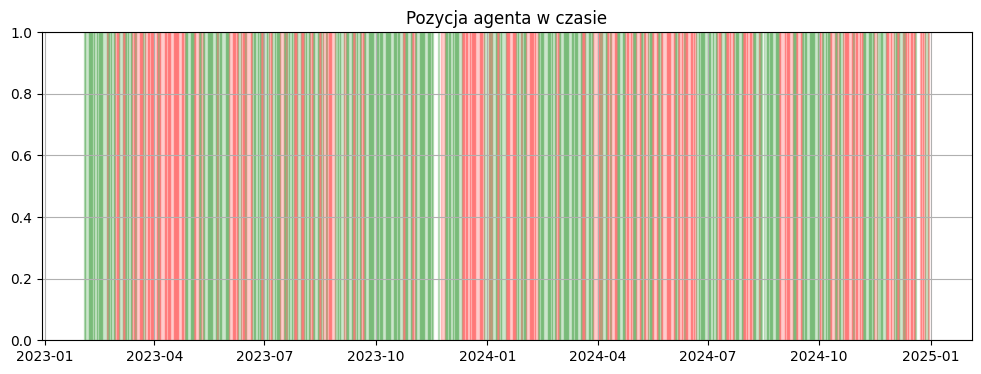

In [171]:
fig, ax = plt.subplots(figsize=(12, 4))

# tło zależne od pozycji
for i in range(len(positions) - 1):
    if positions[i] > 0:      # LONG
        ax.axvspan(
            dates[i], dates[i+1],
            color="green", alpha=0.2
        )
    elif positions[i] < 0:    # SHORT
        ax.axvspan(
            dates[i], dates[i+1],
            color="red", alpha=0.2
        )

ax.set_title("Pozycja agenta w czasie")
ax.grid(True)

plt.show()

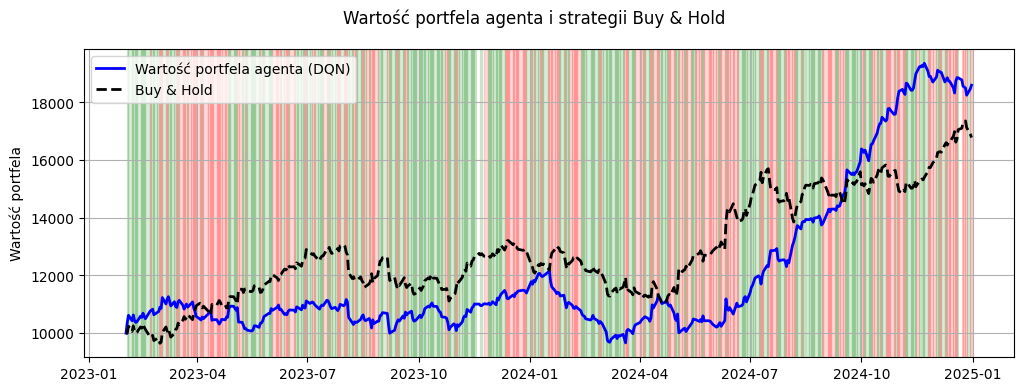

In [172]:
fig, ax = plt.subplots(figsize=(12, 4))

# agent
ax.plot(
    dates,
    portfolio_values,
    label="Wartość portfela agenta (DQN)",
    color="blue",
    linewidth=2
)

# Buy & Hold
ax.plot(
    dates,
    bh_values,
    label="Buy & Hold",
    color="black",
    linestyle="--",
    linewidth=2
)

ax.set_ylabel("Wartość portfela")
ax.grid(True)

# tło zależne od pozycji
for i in range(len(positions) - 1):
    if positions[i] > 0:      # LONG
        ax.axvspan(
            dates[i], dates[i + 1],
            color="green", alpha=0.15
        )
    elif positions[i] < 0:    # SHORT
        ax.axvspan(
            dates[i], dates[i + 1],
            color="red", alpha=0.15
        )

fig.suptitle("Wartość portfela agenta i strategii Buy & Hold")
ax.legend(loc="upper left")

plt.show()
